In [2]:
import numpy as np
import cv2 as cv
import napari
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib

matplotlib.rcParams.update({'font.size': 14})

In [3]:
# visualize all images in list using napari
def visualize_napari(images, labels):
    """ Visualize all images in list using napari
    parameters
    ----------
    imagest: list of numpy images
    labels: list of names for each image
        """
    viewer = napari.Viewer()
    for i, img in enumerate(images):
        viewer.add_image(img, name=labels[i])


# find enclosing ellipse using cv.minAreaRect and add to image
def enclosing_ellipse(img, labels):
    """ Find enclosing ellipse using cv.minAreaRect
    parameters
    ----------
    labels: destination labeled image
    """
    img_copy = img.copy()
    d = []
    area = []
    labels_copy = labels.copy()
    for i in [x for x in np.unique(labels) if (x != -1 and x != 1)]:
        # find all points belonging to object
        points = np.where(labels == i)

        # discard if object is 
        # - too small
        # - too large
        # - at image border
        if len(points[0]) < 1000 \
            or np.subtract(points[0].max(), points[0].min()) > 500 \
            or np.subtract(points[1].max(), points[1].min()) > 500 \
            or points[0].min() == 1 or points[0].max() == labels.shape[0]-2 \
            or points[1].min() == 1 or points[1].max() == labels.shape[1]-2:
            labels_copy[labels_copy == i] = 1
            continue
        
        # find minimal bounding rectangle (possibly rotated)
        points = np.transpose(points)
        (xc, yc), (d1, d2), angle = cv.minAreaRect(points)

        # discard if area of ellipse is significantly bigger than area of object
        # indicating multiple cells being recognized as one
        a = np.pi*(d1/2)*(d2/2)
        if len(points) < 0.9*a:
            labels_copy[labels_copy == i] = 1
            continue

        # discard if ellipse is too far from circle
        # indicating a elongated assembly of cells being recognized as a single cell
        if min(d1, d2)/max(d1, d2) < 0.5:
            labels_copy[labels_copy == i] = 1
            continue
        
        # save diameters and area
        d.append((min(d1, d2), max(d1, d2)))
        area.append(a)

        # add enclosing ellipses around objects
        ellipse = ((int(yc), int(xc)), (int(d2), int(d1)), -angle)
        cv.ellipse(img_copy, ellipse, (0, 255, 0), 3)
    return img_copy, np.array(d), np.array(area), labels_copy


In [5]:
plt.rcParams['figure.figsize'] = [15, 8]

# path to folder containing images
path = 'base_model_pictures'

# list of all filenames in folder
filenames = os.listdir(path)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
results = []
diams = []
area = []
results_cleaned = []

# iterate through all filenames
for filename in filenames:
    # path to image
    file = os.path.join(path, filename)
    print(file)

    # read image
    img = cv.imread(file)

    # convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Gaussian blur to remove noise
    gray = cv.GaussianBlur(gray, (5,5), 0)

    # binarize image using Otsu's method
    ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

    # noise removal by morphological opening
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

    # identify sure background area by dilation
    sure_bg = cv.dilate(opening, kernel, iterations=3)

    # identify sure foreground area by distance transform and thresholding
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    th = dist_transform.mean() + dist_transform.std()
    ret, sure_fg = cv.threshold(dist_transform, th, 255, 0)

    # find unknown region by subtracting sure foreground from sure background
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    # identify foreground objects
    ret, markers = cv.connectedComponents(sure_fg)

    # add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # mark unknown region as 0
    markers[unknown==255] = 0

    # apply watershed algorithm to assign unknown regions to foreground, background or boundary
    labels = cv.watershed(img, markers.copy())
    results.append(labels)
    # plt.imsave('base_model_watershed/' + filename.split('.')[0] + '_wtrshd.tiff', labels)

    # find enclosing ellipses
    img_with_ellipses, d, a, labels_cleaned = enclosing_ellipse(img, labels)

    # calculate diameters and area in mikrometer
    # 100 mikrometer: 94 pixel
    # 1 pixel: 100/94 mikrometer
    # area(pixel) = (100/94)^2 mikrometer^2
    diams.append(d*(100/94))
    area.append(a*((100/94)**2))
    results_cleaned.append(labels_cleaned)

    # plot img_with_ellipses
    # plt.imshow(img_with_ellipses)
    # plt.show()
    # cv.imwrite('base_model_ellipses/' + filename.split('.')[0] + '_elps.tif', img_with_ellipses)

    # visualize result with napari
    # visualize_napari([gray, opening, dist_transform, sure_fg, unknown, markers, result],
    #                  ['gray', 'opening', 'dist_transform', 'sure_fg', 'unknown', 'markers', 'result'])

    

base_model_pictures\20220130_543_D4001_ch00_nn.tif
base_model_pictures\20220302_EXP592_100ML_DAY4002_ch00_yn.tif
base_model_pictures\20220302_EXP593_50ML_DAY4001_ch00_yn.tif
base_model_pictures\20220329_Exp 639 day 4_ch00_yy.tif
base_model_pictures\20220505_681 day 4002_ch00_yy.tif
base_model_pictures\20220528_702 D4001_ch00_yn.tif
base_model_pictures\20220528_703 D4 001_ch00_yn.tif
base_model_pictures\20220528_704 D4 001_ch00_yn.tif
base_model_pictures\20220528_705 D4 001_ch00_yn.tif
base_model_pictures\20220529_709 D4001_ch00_yy.tif
base_model_pictures\20220604_711 day 4001_ch00_yy.tif
base_model_pictures\20220604_712 day 4001_ch00_yy.tif
base_model_pictures\20220604_713 day 4001_ch00_yy.tif
base_model_pictures\20220611_720 DE001_ch00_yy.tif
base_model_pictures\20220616_725 D4001_ch00_yy.tif
base_model_pictures\20220703_740 day 4001_ch00_yy.tif
base_model_pictures\20220806_776 day 4002_ch00_yy.tif
base_model_pictures\20220918_808 D4001_ch00_yn.tif
base_model_pictures\20220918_809 D40

In [6]:
# divide area and diams into three lists depending on suffix of filename (i.e., 'yy', 'yn', 'nn')
area_yy = []
area_yn = []
area_nn = []
diams_yy = []
diams_yn = []
diams_nn = []

for i in range(len(filenames)):
    if filenames[i].split('.')[0][-2:] == 'yy':
        area_yy.append(area[i])
        diams_yy.append(diams[i])
    elif filenames[i].split('.')[0][-2:] == 'yn':
        area_yn.append(area[i])
        diams_yn.append(diams[i])
    elif filenames[i].split('.')[0][-2:] == 'nn':
        area_nn.append(area[i])
        diams_nn.append(diams[i])

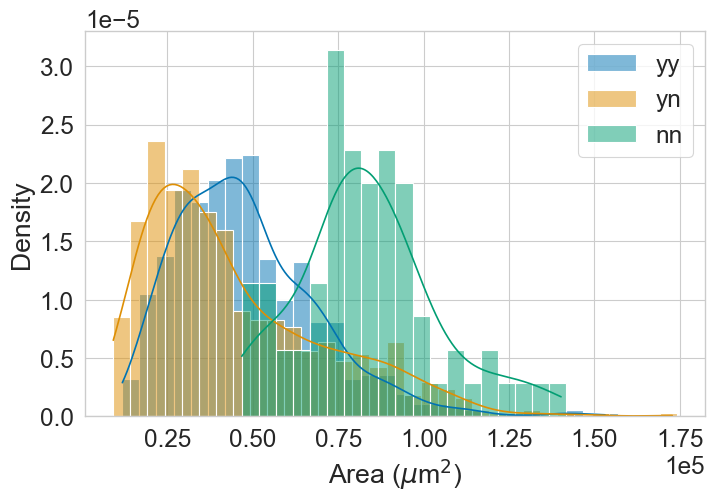

In [12]:
# plot histograms of area for yy, yn and nn

# figure size
plt.rcParams['figure.figsize'] = [8, 5]

# general settings for plots
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=2.0)

# create figure
fig, ax = plt.subplots()
sns.histplot(np.concatenate(area_yy), ax=ax, label='yy', kde=True, binwidth=5000, stat='density')
sns.histplot(np.concatenate(area_yn), ax=ax, label='yn', kde=True, binwidth=5000, stat='density')
sns.histplot(np.concatenate(area_nn), ax=ax, label='nn', kde=True, binwidth=5000, stat='density')
ax.set_xlabel('Area (' + r'$\mu$' + 'm' + r'$^2$' + ')')
ax.set_ylabel('Density')
ax.legend()

# change x-axis format to scientific notation
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

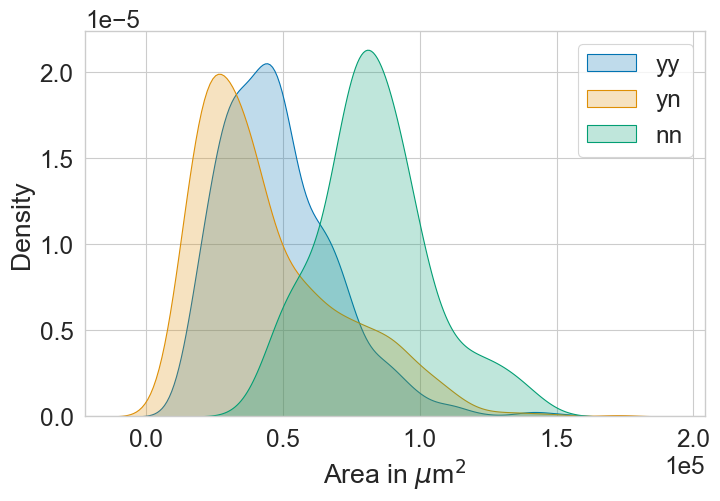

In [11]:
# plot kde plots of area for yy, yn and nn

# general settings for plots
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=2.0)

# create figure
fig, ax = plt.subplots()
sns.kdeplot(np.concatenate(area_yy), ax=ax, fill=True, label='yy')
sns.kdeplot(np.concatenate(area_yn), ax=ax, fill=True, label='yn')
sns.kdeplot(np.concatenate(area_nn), ax=ax, fill=True, label='nn')
plt.xlabel('Area in ' + r'$\mu$' + 'm' + r'$^2$')
plt.ylabel('Density')
plt.legend()

# change x-axis format to scientific notation
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()


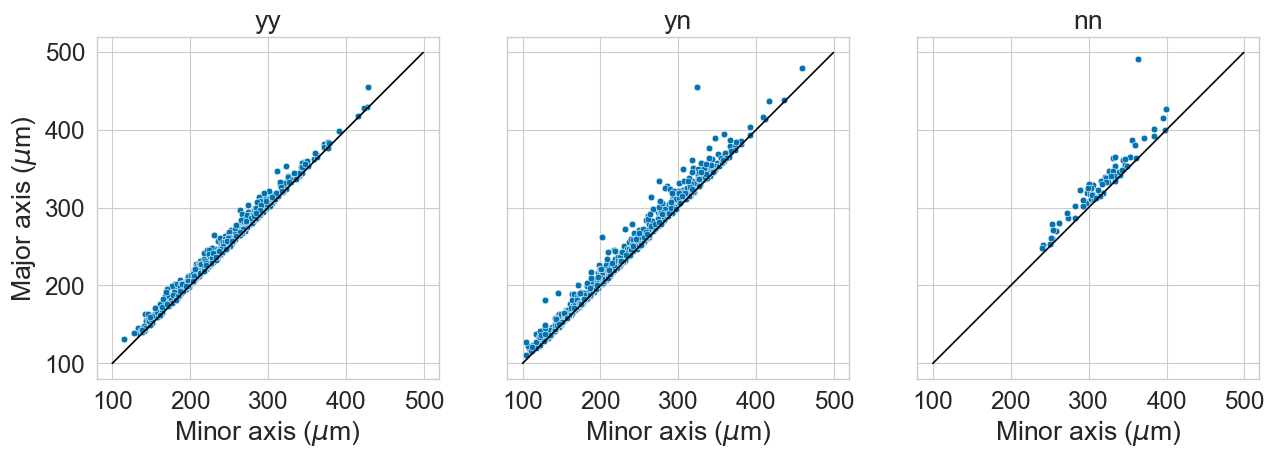

In [50]:
# scatterplot for diams_yy, diams_yn and diams_nn in three subplots

# quadratic grid
plt.rcParams['figure.figsize'] = [15, 5]

# general settings for plots
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=2.0)

# create figure with shared x- and y-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# set ticks and ticklabels for all axes
plt.setp(ax, xticks=np.arange(100,501,100), yticks=np.arange(100,501,100))

# scatterplots
sns.scatterplot(x=np.concatenate(diams_yy).transpose()[0], y=np.concatenate(diams_yy).transpose()[1], ax=ax[0])
sns.scatterplot(x=np.concatenate(diams_yn).transpose()[0], y=np.concatenate(diams_yn).transpose()[1], ax=ax[1])
sns.scatterplot(x=np.concatenate(diams_nn).transpose()[0], y=np.concatenate(diams_nn).transpose()[1], ax=ax[2])

# add diagonal line
sns.lineplot(x=np.arange(100, 500), y=np.arange(100, 500), ax=ax[0], color='black')
sns.lineplot(x=np.arange(100, 500), y=np.arange(100, 500), ax=ax[1], color='black')
sns.lineplot(x=np.arange(100, 500), y=np.arange(100, 500), ax=ax[2], color='black')

# set labels
ax[0].set_xlabel('Minor axis (' + r'$\mu$' + 'm)')
ax[0].set_ylabel('Major axis (' + r'$\mu$' + 'm)')
ax[1].set_xlabel('Minor axis (' + r'$\mu$' + 'm)')
ax[2].set_xlabel('Minor axis (' + r'$\mu$' + 'm)')

# set titles
ax[0].set_title('yy')
ax[1].set_title('yn')
ax[2].set_title('nn')

# axes of equal length
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

# show plot
plt.show()
